# Notes on Gaussian Processes

- #GP https://thegradient.pub/gaussian-process-not-quite-for-dummies/ 
    moves from 2d to 20d 
    
- #GP https://katbailey.github.io/post/gaussian-processes-for-dummies/ 
    nice explanation with python numpy code
    gives code for "intercept" points but with no explanation...
    recommends Kevin Murphy's book "Machine learning: a probabilistic perspective" (in Zotero)
    
- #GP https://distill.pub/2019/visual-exploration-gaussian-processes/
    - interactive graphics
    - examples with different Kernels eg. RBF, periodic, and linear

In [15]:
import altair as alt
import pandas as pd

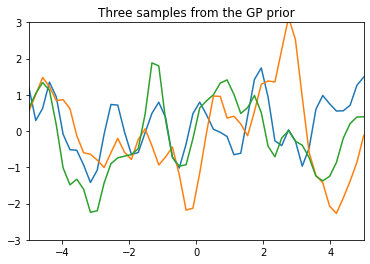

In [188]:
# from file:///Users/josephmann/Zotero/storage/LKECMTX2/gaussian-processes-for-dummies.html
import numpy as np
import matplotlib.pyplot as pl

# Test data
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# Define the kernel function
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

param = 0.1
K_ss = kernel(Xtest, Xtest, param)

# Get cholesky decomposition (square root) of the
# covariance matrix
L = np.linalg.cholesky(K_ss + 1e-15*np.eye(n))
# Sample 3 sets of standard normals for our test points,
# multiply them by the square root of the covariance matrix
f_prior = np.dot(L, np.random.normal(size=(n,3)))

# Now let's plot the 3 sampled functions.
pl.plot(Xtest, f_prior)
pl.axis([-5, 5, -3, 3])
pl.title('Three samples from the GP prior')
pl.show()


In [189]:
a = b = Xtest

In [190]:
# so... shapes (x,1) + (x) --> (x,x)
(np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1)).shape

(50, 50)

In [191]:
# so... shapes (x,1) + (x) == (x,1) + (1,x) --> (x,x)
(np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1).reshape(1,-1)).shape

(50, 50)

In [192]:
# Noiseless training data
Xtrain = np.array([-4, -3, -2, -1, 1]).reshape(5,1)
ytrain = np.sin(Xtrain)

# Apply the kernel function to our training points
K = kernel(Xtrain, Xtrain, param)
L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

# Compute the mean at our test points.
K_s = kernel(Xtrain, Xtest, param)
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)
# Draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))

In [193]:
num_generated_samples = 50
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,num_generated_samples)))
y_d = {f'y{i}': f_post[:,i] for i in np.arange(f_post.shape[1])}
test_df = pd.DataFrame({'x':Xtest.reshape((-1),), 'mu': mu, 'lo': mu-2*stdv,'hi': mu+2*stdv,**y_d})
train_df = pd.DataFrame({'x':Xtrain.reshape((-1,)), 'y':ytrain.reshape((-1,))})

# test_df = pd.DataFrame({'x': Xtest.reshape((-1,)), 'y': pd.DataFrame(y_d)})

base_train_c = alt.Chart(train_df) 

train_c = base_train_c.mark_point(size=50, color='black').encode(
    x='x:Q',
    y='y:Q')

base_test_c = alt.Chart(test_df)

test_c = base_test_c.mark_line(opacity = 0.2 + 1/num_generated_samples).transform_fold(
    fold= list(test_df.columns[4:]),
    as_=['category', 'y']
).encode(
    x='x:Q',
    y='y:Q',
#     color=alt.Color('category:N', legend=None)
    detail='category:N'
)

mu_c = base_test_c.mark_line(color='black', strokeDash=[8,4],size=3).encode(
    x='x:Q',
    y='mu:Q',
)

fill_c = base_test_c.mark_area(opacity=0.2, color='blue').encode(
    x='x:Q',
    y='lo:Q',
    y2='hi:Q'
)

# test_df = pd.DataFrame({'x': Xtest, 'y': f_post})
(test_c + train_c + mu_c  + fill_c ).properties(title='Three samples from the GP posterior', width=600)

alt.LayerChart(...)

In [187]:
num_generated_samples = 50
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,num_generated_samples)))
y_d = {f'y{i}': f_post[:,i] for i in np.arange(f_post.shape[1])}
test_df = pd.DataFrame({'x':Xtest.reshape((-1),), 'mu': mu, 'lo': mu-2*stdv,'hi': mu+2*stdv,**y_d})
train_df = pd.DataFrame({'x':Xtrain.reshape((-1,)), 'y':ytrain.reshape((-1,))})

# test_df = pd.DataFrame({'x': Xtest.reshape((-1,)), 'y': pd.DataFrame(y_d)})

base_train_c = alt.Chart(train_df) 

train_c = base_train_c.mark_point(size=50, color='black').encode(
    x='x:Q',
    y='y:Q')

base_test_c = alt.Chart(test_df)

test_c = base_test_c.mark_line(opacity = 0.2 + 1/num_generated_samples).transform_fold(
    fold= list(test_df.columns[4:]),
    as_=['category', 'y']
).encode(
    x='x:Q',
    y='y:Q',
#     color=alt.Color('category:N', legend=None)
    detail='category:N'
)

mu_c = base_test_c.mark_line(color='black', strokeDash=[8,4],size=3).encode(
    x='x:Q',
    y='mu:Q',
)

fill_c = base_test_c.mark_area(opacity=0.2, color='blue').encode(
    x='x:Q',
    y='lo:Q',
    y2='hi:Q'
)

# test_df = pd.DataFrame({'x': Xtest, 'y': f_post})
(test_c + train_c + mu_c  + fill_c ).properties(title='Three samples from the GP posterior', width=600)

alt.LayerChart(...)

In [181]:
j_heatmap(L@L)

alt.Chart(...)

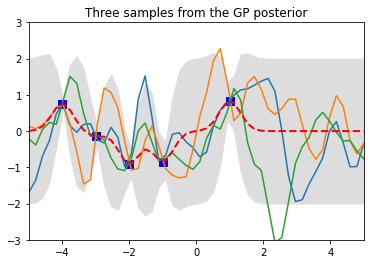

In [43]:
pl.plot(Xtrain, ytrain, 'bs', ms=8)
pl.plot(Xtest, f_post)
pl.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
pl.plot(Xtest, mu, 'r--', lw=2)
pl.axis([-5, 5, -3, 3])
pl.title('Three samples from the GP posterior')
pl.show()

In [19]:
eps = 0.00001
xs = np.linspace(eps,1-eps,100)
_df = pd.DataFrame({'x': xs, 'y': np.log(xs / (1-xs))})
alt.Chart(_df).mark_line().encode(x='x:Q',y='y:Q')

alt.Chart(...)

In [152]:
_a = np.random.randn(10,10)
def j_heatmap(_a, x_size=600):
    idx_names = [f'x{i:02}' for i in np.arange(_a.shape[1])]
    _df = pd.DataFrame({idx_names[i]:_a[:,i] for i in np.arange(_a.shape[1])}) #, index=idx_names)
    # _df.melt().reset_index()
    c_df = _df.reset_index().melt(id_vars='index')

    c= alt.Chart(c_df, ).mark_rect().encode(
        x = alt.X('index:N', axis=None),
        y = alt.Y('variable:N', axis=None),
        color = alt.Color('value:Q', legend=None)
    ).properties(width=x_size, height= x_size * _a.shape[1]/_a.shape[0] )
    return c

In [154]:
_a = np.random.randn(10,20)
j_heatmap(_a, x_size=100)

alt.Chart(...)